In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#change in batchsize gave much better val accuracy
image_size = (256, 256)

class_names = ['Correct', 'Incorrect Mask']
input_shape=(None, None, 3)
num_classes = 2

#Hyperparams
batch_size = 16
epochs = 50
#adam optimzier learning rate
init_LR = 0.007

#pull in folder
myFile = "E:\Downloads\SmallML"
fullPath = os.path.abspath("./" + myFile)
data_for_processing = keras.utils.get_file(myFile,'file://'+fullPath)


x_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_for_processing,
    validation_split=0.3,
    subset="training",
    seed=1000,
    image_size=image_size,
    batch_size=batch_size,
)

x_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_for_processing,
    validation_split=0.4,
    subset="validation",
    seed=1000,
    image_size=image_size,
    batch_size=batch_size,
)
    


Found 1906 files belonging to 2 classes.
Using 1335 files for training.
Found 1906 files belonging to 2 classes.
Using 762 files for validation.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in x_train.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
x_train = x_train.cache().prefetch(buffer_size=AUTOTUNE)
x_val = x_val.cache().prefetch(buffer_size=AUTOTUNE)


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
# 1 - Convolution
    tf.keras.layers.Conv2D(256,3, padding = 'same', input_shape=(256, 256,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

# 2nd Convolution layer
    tf.keras.layers.Conv2D(256,3,padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

# 3rd Convolution layer
    tf.keras.layers.Conv2D(126,3,padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

# 4th Convolution layer
   
    tf.keras.layers.Conv2D(32,3,padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

# Flattening
    tf.keras.layers.Flatten(),

# Fully connected layer 1st layer
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

# Fully connected layer 2nd layer
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
# actual classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=init_LR)

model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['accuracy']
)


history = model.fit(
    x_train,
    validation_data=x_val,
    epochs=epochs
)
model.save("Face_Mask_Model")

In [ ]:
print(history.params)
print(history.history.keys())
print(history.history['accuracy'])
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()



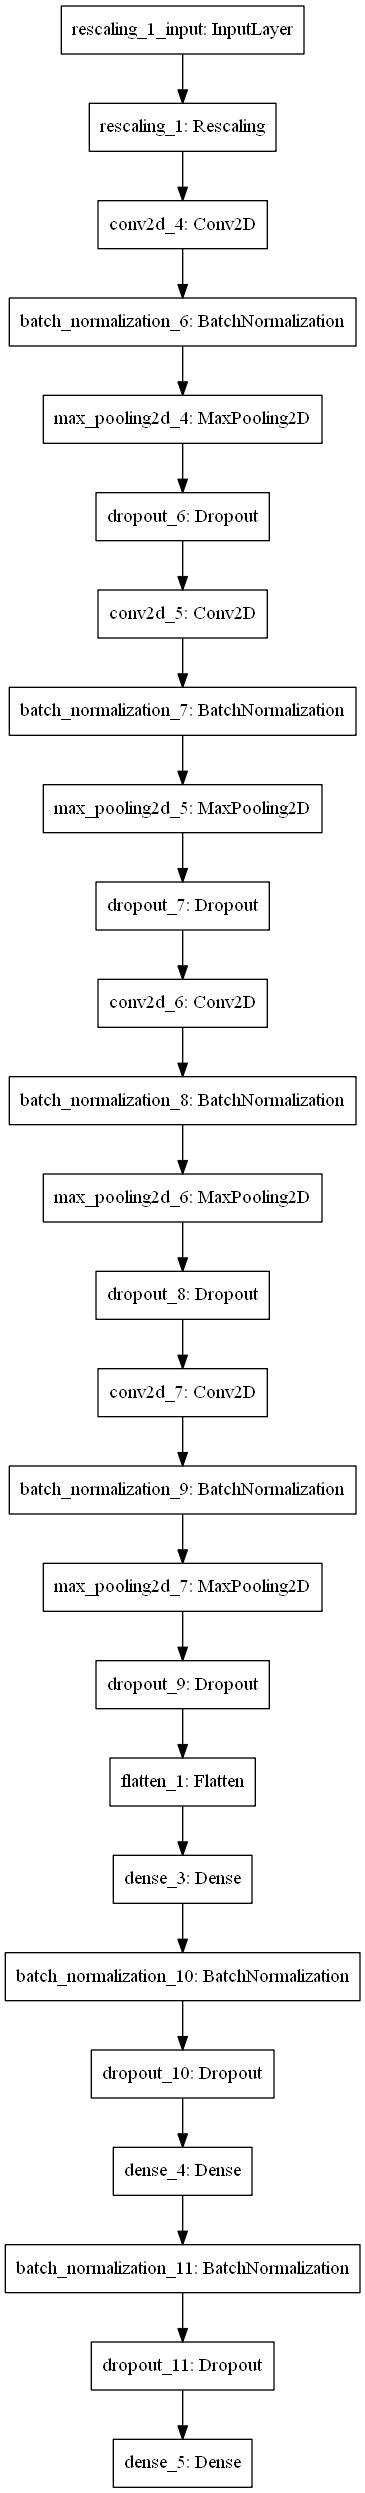

In [6]:
###### start here for testing #######

from tensorflow import keras

#load Keras model
model =  keras.models.load_model("Face_Mask_Model")
#plot model
keras.utils.plot_model(model,"Face_Mask.png")

In [11]:
#load from USB camera
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
face_model =cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
import matplotlib.pyplot as plt
import serial
import time

#for overlay
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,256)
font_scale= 1
font_color = (0, 0, 0)
thickness= 2
line_type = 2

text = ""
img_counter = 0
save_name = "test_img"
com_port = 'COM7'
cam_ID = 0
num = 0

#Arduino setup
arduino = serial.Serial(com_port, baudrate=115200, timeout=.1)

def write_read(x):
    arduino.write(bytes(x))
    time.sleep(0.05)
    data = arduino.readline()
    return data


# Open the device at the ID 0
cap = cv2.VideoCapture(cam_ID)
#Check whether user selected camera is opened successfully.
if not (cap.isOpened()):
    print("Could not open video device")

#Prediction loop    
while True: 
    #grab image from USB camera, save and open to get display working
    _, frame = cap.read()
    img_name = "opencv_frame_{}.png".format(save_name)
    cv2.imwrite(img_name, frame)
    
    #print("{} written!".format(img_name))
    img =  cv2.imread(img_name)
    
    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(256,256))
        crop = np.reshape(crop,[1,256,256,3])
        prediction = model.predict(crop)
        print(prediction)
        
        
        if prediction >= 0.90:        
            print("No Mask")
            text = "Incorrect Mask"
            font_color = (255,0,0)
            num = 0
        
        elif prediction < 0.90: 
            print("Mask")
            text = "correct Mask"  
            font_color = (0,255,0)
            num = 1
            
        cv2.putText(frame,
                    text,
                    (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    font_color,
                    thickness,
                    line_type)
        
        cv2.rectangle(frame,
                      (x,y),
                      (x+w,y+h),
                      font_color,
                      thickness)
        
    cv2.imshow("Prediction", frame)
    
    #Serial out for Arduino
    value = write_read(num)
    
    #camera exit control
    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing")
        break


cap.release()
cv2.destroyAllWindows()

[[0.999995]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999938]]
No Mask
[[0.9999932]]
No Mask
[[0.9999932]]
No Mask
[[0.9999944]]
No Mask
[[0.9999945]]
No Mask
[[0.99999404]]
No Mask
[[0.99999285]]
No Mask
[[0.9999927]]
No Mask
[[0.9999926]]
No Mask
[[0.9999924]]
No Mask
[[0.99999297]]
No Mask
[[0.9999925]]
No Mask
[[0.9999931]]
No Mask
[[0.99999285]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.08502475]]
Mask
[[0.9999944]]
No Mask
[[0.07546906]]
Mask
[[0.98662347]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.9999931]]
No Mask
[[0.99999297]]
No Mask
[[0.9999933]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.9999912]]
No Mask
[[0.99999034]]
No Mask
[[0.01059071]]
Mask
[[0.9999933]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.9999939]]
No Mask
[[0

[[0.99999475]]
No Mask
[[0.99999475]]
No Mask
[[0.99999475]]
No Mask
[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.99999404]]
No Mask
[[0.08901404]]
Mask
[[0.999995]]
No Mask
[[0.14897619]]
Mask
[[0.99999523]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0.99999344]]
No Mask
[[0.99999285]]
No Mask
[[0.99999285]]
No Mask
[[0.9999925]]
No Mask
[[0.99999416]]
No Mask
[[0.9999943]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.9999943]]
No Mask
[[0.9999925]]
No Mask
[[0.9999926]]
No Mask
[[0.9999945]]
No Mask
[[0.9999939]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.07791482]]
Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.999

[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.99999535]]
No Mask
[[0.9999944]]
No Mask
[[0.9999938]]
No Mask
[[0.9999932]]
No Mask
[[0.999992]]
No Mask
[[0.9999925]]
No Mask
[[0.9999933]]
No Mask
[[0.99999416]]
No Mask
[[0.9999919]]
No Mask
[[0.9999939]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
No Mask
[[0.9999949]]
No Mask
[[0.99999404]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999464]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.13422424]]
Mask
[[0.01505382]]
Mask
[[0.9999949]]
No Mask
[[0.9999949]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.01727589]]
Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.01313246]]
Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0

[[0.99999285]]
No Mask
[[0.99999225]]
No Mask
[[0.9999932]]
No Mask
[[0.9999924]]
No Mask
[[0.9999924]]
No Mask
[[0.99999297]]
No Mask
[[0.99999154]]
No Mask
[[0.99999344]]
No Mask
[[0.9999932]]
No Mask
[[0.9999932]]
No Mask
[[0.99999225]]
No Mask
[[0.99999297]]
No Mask
[[0.9999926]]
No Mask
[[0.9999939]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.9999944]]
No Mask
[[0.9999939]]
No Mask
[[0.9999914]]
No Mask
[[0.99999464]]
No Mask
[[0.99999416]]
No Mask
[[0.9999938]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.03516152]]
Mask
[[0.9999933]]
No Mask
[[0.9999931]]
No Mask
[[0.9999933]]
No Mask
[[0.9999919]]
No Mask
[[0.99999464]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.99999404]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.999992]]
No Mask
[[0.9999951]]
No Mas

[[0.99999535]]
No Mask
[[0.9999956]]
No Mask
[[0.99999523]]
No Mask
[[0.9999956]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999956]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.9999956]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0

[[0.9999943]]
No Mask
[[0.00447396]]
Mask
[[0.99999464]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.9999938]]
No Mask
[[0.9999944]]
No Mask
[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.99999475]]
No Mask
[[0.9999939]]
No Mask
[[0.999995]]
No Mask
[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.9999943]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.9999919]]
No Mask
[[0.99999404]]
No Mask
[[0.99999547]]
No Mask
[[0.9999949]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]
N

[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.9999949]]
No Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.00739519]]
Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mas

[[0.9999937]]
No Mask
[[0.9999945]]
No Mask
[[0.9999924]]
No Mask
[[0.99999523]]
No Mask
[[0.99999416]]
No Mask
[[0.999995]]
No Mask
[[0.99999547]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999225]]
No Mask
[[0.99999404]]
No Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.99999475]]
No Mask
[[0.9999943]]
No Mask
[[0.9999949]]
No Mask
[[0.99999523]]
No Mask
[[0.9999925]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.9999943]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.9999925]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999937]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.9

[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999297]]
No Mask
[[0.9999924]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.99999464]]
No Mask
[[0.9999956]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.9999951]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.99999225]]
No Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No M

[[0.9999951]]
No Mask
[[0.9999932]]
No Mask
[[0.9999926]]
No Mask
[[0.9999918]]
No Mask
[[0.99999356]]
No Mask
[[0.9999943]]
No Mask
[[0.9999949]]
No Mask
[[0.99999154]]
No Mask
[[0.999995]]
No Mask
[[0.99999213]]
No Mask
[[0.9999925]]
No Mask
[[0.99999475]]
No Mask
[[0.9999931]]
No Mask
[[0.99999416]]
No Mask
[[0.9999933]]
No Mask
[[0.9999918]]
No Mask
[[0.9999925]]
No Mask
[[0.9999949]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]
No Mask
[[0.99999475]]
No Mask
[[0.9999927]]
No Mask
[[0.99999464]]
No Mask
[[0.9999926]]
No Mask
[[0.99999154]]
No Mask
[[0.99999475]]
No Mask
[[0.99999297]]
No Mask
[[0.99999225]]
No Mask
[[0.9999906]]
No Mask
[[0.9999931]]
No Mask
[[0.999992]]
No Mask
[[0.9999927]]
No Mask
[[0.99999464]]
No Mask
[[0.9999926]]
No Mask
[[0.9999912]]
No Mask
[[0.9999938]]
No Mask
[[0.99999285]]
No Mask
[[0.99999225]]
No Mask
[[0.999995]]
No Mask
[[0.99999213]]
No Mask
[[0.99999297]]
No Mask
[[0.99999523]]
No Mask
[[0.9999925]]
No Mask
[[0.99999344]]
No Mask
[[0.9999949]]
No 

[[0.08480229]]
Mask
[[0.9999931]]
No Mask
[[0.9999927]]
No Mask
[[0.99999225]]
No Mask
[[0.9999932]]
No Mask
[[0.99999404]]
No Mask
[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999933]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999914]]
No Mask
[[0.9999919]]
No Mask
[[0.9999925]]
No Mask
[[0.99999166]]
No Mask
[[0.99999344]]
No Mask
[[0.9999926]]
No Mask
[[0.9999933]]
No Mask
[[0.9999927]]
No Mask
[[0.99999225]]
No Mask
[[0.99999154]]
No Mask
[[0.9999937]]
No Mask
[[0.99999166]]
No Mask
[[0.9999943]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999938]]
No Mask
[[0.99999344]]
No Mask
[[0.9999925]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939

[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.9999933]]
No Mask
[[0.9999919]]
No Mask
[[0.99999344]]
No Mask
[[0.9999927]]
No Mask
[[0.9999914]]
No Mask
[[0.9999925]]
No Mask
[[0.99999166]]
No Mask
[[0.9999919]]
No Mask
[[0.9999927]]
No Mask
[[0.99999046]]
No Mask
[[0.03143416]]
Mask
[[0.01690154]]
Mask
[[0.9999908]]
No Mask
[[0.01983053]]
Mask
[[0.9999912]]
No Mask
[[0.99999154]]
No Mask
[[0.9999902]]
No Mask
[[0.9999906]]
No Mask
[[0.9999925]]
No Mask
[[0.99999404]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
No Mask
[[0.9999932]]
No Mask
[[0.9999925]]
No Mask
[[0.99999046]]
No Mask
[[0.99999225]]
No Mask
[[0.9999933]]
No Mask
[[0.9999908]]
No Mask
[[0.9999925]]
No Mask
[[0.99999285]]
No Mask
[[0.99999344]]
No Ma

[[0.9999944]]
No Mask
[[0.9999933]]
No Mask
[[0.99999344]]
No Mask
[[0.99999297]]
No Mask
[[0.99999285]]
No Mask
[[0.9999943]]
No Mask
[[0.99999356]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0.9999943]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.9999937]]
No Mask
[[0.9999914]]
No Mask
[[0.02230336]]
Mask
[[0.9999926]]
No Mask
[[0.9999925]]
No Mask
[[0.08011145]]
Mask
[[0.00966308]]
Mask
[[0.99999225]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mask
[[0.99999404]]
No Mask
[[0.99999416]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.00754151]]
Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.00948544]]
Mask
[[0.9999945]]
No Mask
[[0.9999949]]
No Mask
[[0.99999225]]
No Mask
[[0.999995]]
No Mask
[[0.00856508]]
Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999475]]
No Mask
[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.99999535]]
No Mask
[[0.01075757]]
Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.999994

[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.9999908]]
No Mask
[[0.9999914]]
No Mask
[[0.9999927]]
No Mask
[[0.9999924]]
No Mask
[[0.999995]]
No Mask
[[0.99999166]]
No Mask
[[0.9999927]]
No Mask
[[0.9999924]]
No Mask
[[0.9999924]]
No Mask
[[0.99999094]]
No Mask
[[0.9999925]]
No Mask
[[0.9999912]]
No Mask
[[0.99999404]]
No Mask
[[0.9999956]]
No Mask
[[0.99999523]]
No Mask
[[0.99999166]]
No Mask
[[0.9999956]]
No Mask
[[0.9999927]]
No Mask
[[0.99999547]]
No Mask
[[0.99999285]]
No Mask
[[0.9999957]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999166]]
No Mask
[[0.9999932]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.9999918]]
No Mask
[[0.9999945]]
No Mask
[[0.9999937]]
No Mask
[[0.9999927]]
No Mask
[[0.9999951]]
No Mask
[[0.9999937]]
No Mask
[[0.9999939]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.9999939]]
No Mask
[[0.99999154]]
No Mask
[[0.99999356]]
No Mask
[[0.99999166]]
No Mask
[[0.999992]]
No Mask
[[0.99999213]]
No M

[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.07444464]]
Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.9999945]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.99999356]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.9999956]]
No Mask
[[0.99999464]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999938]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.0127347]]
Mask
[[0.01447041]]
Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.99999356]]
No Mask
[[0.9999956]]
No Mask
[[0.9999949]]
No Mask
[[0.9999944]]
No Mask
[[0.99999344]]
No Mask
[[0.99999416]]
No Mask
[[0.02177834]]
Mask
[[0.9999926]]
No Mask
[[0.99999225]]
No Mask
[[0.99999344]]
No Mask
[[0.999995]]
No Mask
[[0.9999949]]
No Mask
[[0.99999547]]
No Mask
[[0.99999475]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0

[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.9999937]]
No Mask
[[0.99999464]]
No Mask
[[0.02590965]]
Mask
[[0.99999475]]
No Mask
[[0.04002595]]
Mask
[[0.9999945]]
No Mask
[[0.02245823]]
Mask
[[0.9999932]]
No Mask
[[0.99999285]]
No Mask
[[0.99999464]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999464]]
No Mask
[[0.99999535]]
No Mask
[[0.99999154]]
No Mask
[[0.9999926]]
No Mask
[[0.9999943]]
No Mask
[[0.9999951]]
No Mask
[[0.99999464]]
No Mask
[[0.99999547]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999937]]
No Mask
[[0.9999939]]
No Mask
[[0.9999931]]
No Mask
[[0.99999416]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.9999926]]
No Mask
[[0.99999535]]
No Mask
[[0.9999949]]
No Mask
[[0.9999943]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
N

[[0.999995]]
No Mask
[[0.99999547]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999464]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.9999939]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.99999416]]
No Mask
[[0.9999937]]
No Mask
[[0.9999944]]
No Mask
[[0.00541704]]
Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.9999945]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.99999356]]
No Mask
[[0.9999932]]
No Mask
[[0.9999933]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.9999939]]
No Mask
[[0.99999416]]
No Mask
[[0.9999945]]
No Mask

[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.99999464]]
No Mask
[[0.99999404]]
No Mask
[[0.9999949]]
No Mask
[[0.9999932]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.999992]]
No Mask
[[0.9999914]]
No Mask
[[0.9999908]]
No Mask
[[0.99999464]]
No Mask
[[0.9999933]]
No Mask
[[0.99999416]]
No Mask
[[0.96793514]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.9999949]]
No Mask
[[0.99999356]]
No Mask
[[0.40419787]]
Mask
[[0.9999951]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.999995]]
No Mask
[[0.35345933]]
Mask
[[0.9999944]]
No Mask
[[0.316282]]
Mask
[[0.9999951]]
No Mask
[[0.29029828]]
Mask
[[0.200967]]
Mask
[[0.26507285]]
Mask
[[0.9999913]]
No Mask
[[0.99999535]]
No Mask
[[0.23892216]]
Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No M

[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.00434286]]
Mask
[[0.01015212]]
Mask
[[0.99999464]]
No Mask
[[0.00364069]]
Mask
[[0.99999464]]
No Mask
[[0.00810247]]
Mask
[[0.9999943]]
No Mask
[[0.00559335]]
Mask
[[0.9999939]]
No Mask
[[0.9999944]]
No Mask
[[0.00532074]]
Mask
[[0.00531101]]
Mask
[[0.9999949]]
No Mask
[[0.00737873]]
Mask
[[0.9999943]]
No Mask
[[0.01069755]]
Mask
[[0.9999938]]
No Mask
[[0.01043435]]
Mask
[[0.99999416]]
No Mask
[[0.00787373]]
Mask
[[0.99999464]]
No Mask
[[0.00892011]]
Mask
[[0.99999416]]
No Mask
[[0.00835798]]
Mask
[[0.00914616]]
Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.00911075]]
Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.01373468]]
Mask
[[0.9999949]]
No Mask
[[0.00718488]]
Mask
[[0.01324121]]
Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999956]]
No Mask
[[0.00454185]]
Mask
[[0.99999523]]
No Mask
[[0.99999297]]
No Mask
[[0.00566411]]
Mask
[[0.00945124]]
Mask
[[0.9999938]]
No Mas

[[0.9999945]]
No Mask
[[0.9999939]]
No Mask
[[0.01151924]]
Mask
[[0.01472231]]
Mask
[[0.0203295]]
Mask
[[0.01309183]]
Mask
[[0.01541186]]
Mask
[[0.02085259]]
Mask
[[0.99999416]]
No Mask
[[0.01043839]]
Mask
[[0.9999943]]
No Mask
[[0.99999475]]
No Mask
[[0.9999949]]
No Mask
[[0.9999943]]
No Mask
[[0.9999949]]
No Mask
[[0.9999863]]
No Mask
[[0.99999404]]
No Mask
[[0.9999678]]
No Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.99999404]]
No Mask
[[0.9999937]]
No Mask
[[0.99998724]]
No Mask
[[0.99999475]]
No Mask
[[0.99999416]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.9999951]]
No Mask
[[0.9999938]]
No Mask
[[0.99999404]]
No Mask
[[0.9999938]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.99999475]]
No Mask
[[0.9999944]]
No Mask
[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999939]]
No Mask
[[0.999

[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.99999547]]
No Mask
[[0.9999951]]
No Mask
[[0.99999416]]
No Mask
[[0.9999933]]
No Mask
[[0.9999933]]
No Mask
[[0.9999944]]
No Mask
[[0.9999938]]
No Mask
[[0.9999933]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.99999475]]
No Mask
[[0.9999945]]
No Mask
[[0.99999464]]
No Mask
[[0.9999944]]
No Mask
[[0.9999932]]
No Mask
[[0.9999919]]
No Mask
[[0.99999464]]
No Mask
[[0.9999943]]
No Mask
[[0.9999933]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999]]
No Mask
[[0.999995]]
No Mask
[[0.99998975]]
No Mask
[[0.9999938]]
No Mask
[[0.99999475]]
No Mask
[[0.9999944]]
No Mask
[[0.9999933]]
No Mask
[[0.99999285]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.99999535]]
No Mask
[[0.9999944]]
No Mask
[[0.9999919]]
No Mask
[[0.99999094]]
No Ma

[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.9999949]]
No Mask
[[0.9999938]]
No Mask
[[0.9999933]]
No Mask
[[0.99999416]]
No Mask
[[0.9999951]]
No Mask
[[0.9999939]]
No Mask
[[0.99999464]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999404]]
No Mask
[[0.99999356]]
No Mask
[[0.99999535]]
No Mask
[[0.9999957]]
No Mask
[[0.9999956]]
No Mask
[[0.99999547]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.9999945]]
No Mask
[[0.99999475]]
No Mask
[[0.9999944]]
No Mask
[[0.9999938]]
No Mask
[[0.99999404]]
No Mask
[[0.99999416]]
No Mask
[[0.999995]]
No Mask
[[0.99999404]]
No Mask
[[0.9999938]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.9999938]]
No Mask
[[0.99999475]]
No Mask
[[0.99999523]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999297]]
No Mask
[[0.9999931]]
No Mask
[[0.9999927]]
No Mask
[[0.9999933]]
No Mask
[[0.9999932]]
No Mask
[[0.9999931]]
N

[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.9999945]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.9999945]]
No Mask
[[0.9999949]]
No Mask
[[0.99999404]]
No Mask
[[0.9999927]]
No Mask
[[0.9999937]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999956]]
No Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.99999547]]
No Mask
[[0.99999416]]
No Mask
[[0.99999535]]
No Mask
[[0.9999939]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999475]]
No Mask
[[0.9999932]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.9999956]]
No Mask
[[0.9999938]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999938]]
No Mask
[[0.99999523]]
No Mask
[[0.9999932]]
No Mask
[[0.99999547]]
No Mask


[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.9999956]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.99999523]]
No Mask
[[0.9999932]]
No Mask
[[0.99999523]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999943]]
No Mask
[[0.9999939]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999475]]
No Mask
[[0.9999938]]
No Mask
[[0.9999938]]
No Mask
[[0.9999939]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.9999938]]
No Mask
[[0.99999475]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999938]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.9999956]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999956]]
No Mask
[[0.99999535]]
No Mask
[[0.99999475]]
No Mask
[[0.9999938]]
No Mask
[[0.9999933]]
No Mask
[[0.99999475]]
No Mask
[[0.99999416]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No M

[[0.9999938]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.9999937]]
No Mask
[[0.9999932]]
No Mask
[[0.9999933]]
No Mask
[[0.99999297]]
No Mask
[[0.9999937]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.9999943]]
No Mask
[[0.99999356]]
No Mask
[[0.9999931]]
No Mask
[[0.99999297]]
No Mask
[[0.99999297]]
No Mask
[[0.9999933]]
No Mask
[[0.99999297]]
No Mask
[[0.99999464]]
No Mask
[[0.9999943]]
No Mask
[[0.99999475]]
No Mask
[[0.9999937]]
No Mask
[[0.99999475]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.99999297]]
No Mask
[[0.99999297]]
No Mask
[[0.9999932]]
No Mask
[[0.99999285]]
No Mask
[[0.9999932]]
No Mask
[[0.9999937]]
No Mask
[[0.99999297]]
No Mask
[[0.9999931]]
No Mask
[[0.9999907]]
No Mask
[[0.9999943]]
No Mask
[[0.9999945]]
No Mask
[[0.99999416]]
No Mask
[[0.9999938]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.99999285]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999939]]
No Mask
[[0.99999404]]

[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.999995]]
No Mask
[[0.9999938]]
No Mask
[[0.99999344]]
No Mask
[[0.9999939]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999356]]
No Mask
[[0.99999285]]
No Mask
[[0.99999297]]
No Mask
[[0.99999344]]
No Mask
[[0.00517512]]
Mask
[[0.09614514]]
Mask
[[0.00392755]]
Mask
[[0.99999356]]
No Mask
[[0.99999297]]
No Mask
[[0.99999166]]
No Mask
[[0.99999475]]
No Mask
[[0.9999938]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.99999547]]
No Mask
[[0.99999547]]
No Mask
[[0.9999956]]
No Mask
[[0.9999932]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.99999285]]
No Mask
[[0.99999523]]
No Mask
[[0.9999819]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.9999919]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]


[[0.9999937]]
No Mask
[[0.9999933]]
No Mask
[[0.99999297]]
No Mask
[[0.9999933]]
No Mask
[[0.99999404]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999356]]
No Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999416]]
No Mask
[[0.99999285]]
No Mask
[[0.9999933]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.9999949]]
No Mask
[[0.99999344]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.99999356]]
No Mask
[[0.999995]]
No Mask
[[0.9999938]]
No Mask
[[0.999995]]
No Mask
[[0.99999416]]
No Mask
[[0.99999356]]
No Mask
[[0.99999356]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.99999475]]
No Mask
[[0.9999943]]
No Mask
[[0.99999416]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.9999937]]
No Mask
[[0.99999547]]
No Mask
[[0.99999547]]
No Mask
[[0.9999938]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.9999949]]
No Mask
[[0.9999937]]


[[0.99999356]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999464]]
No Mask
[[0.9999937]]
No Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.12085835]]
Mask
[[0.10432047]]
Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No Mask
[[0.999995]]
No Mask
[[0.9999939]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.999995]]
No Mask
[[0.9999949]]
No Mask
[[0.19465941]]
Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999416]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.99999356]]
No Mask
[[0.99998605]]
No Mask
[[0.99999344]]
No Mask
[[0.9999927]]
No Mask
[[0.9999927]]
No Mask
[[0.9999927]]
No Mask
[[0.9999932]]
No Mask
[[0.9999926]]
No Mask
[[0.9999927]]
No Mask
[[0.9

[[0.99999285]]
No Mask
[[0.99999356]]
No Mask
[[0.9999938]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mask
[[0.9999932]]
No Mask
[[0.9999926]]
No Mask
[[0.99999297]]
No Mask
[[0.04952721]]
Mask
[[0.9999932]]
No Mask
[[0.9999932]]
No Mask
[[0.99999297]]
No Mask
[[0.99999356]]
No Mask
[[0.99999356]]
No Mask
[[0.9999931]]
No Mask
[[0.99999285]]
No Mask
[[0.9999927]]
No Mask
[[0.99999297]]
No Mask
[[0.9999931]]
No Mask
[[0.9999924]]
No Mask
[[0.9999931]]
No Mask
[[0.9999949]]
No Mask
[[0.9999945]]
No Mask
[[0.99999344]]
No Mask
[[0.9999925]]
No Mask
[[0.99999225]]
No Mask
[[0.99999297]]
No Mask
[[0.9999893]]
No Mask
[[0.9999919]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.99999213]]
No Mask
[[0.99999464]]
No Mask
[[0.9999932]]
No Mask
[[0.9999926]]
No Mask
[[0.9999925]]
No Mask
[[0.99999285]]
No Mask
[[0.9999927]]
No Mask
[[0.999992]]
No Mask
[[0.99999285]]
No Mask
[[0.9999926]]
No Mask
[[0.99999285]]
No Mask
[[0.99999285]]
No Mask
[[0.9999924]]
No Mask
[[0.99999344]]
N

[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.9999951]]
No Mask
[[0.99999475]]
No Mask
[[0.99999523]]
No Mask
[[0.9999945]]
No Mask
[[0.9999938]]
No Mask
[[0.9999943]]
No Mask
[[0.9999933]]
No Mask
[[0.9999938]]
No Mask
[[0.9999925]]
No Mask
[[0.9999933]]
No Mask
[[0.9999927]]
No Mask
[[0.99999297]]
No Mask
[[0.99999297]]
No Mask
[[0.99999344]]
No Mask
[[0.9999932]]
No Mask
[[0.99999297]]
No Mask
[[0.9999945]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No Mask
[[0.99999344]]
No Mask
[[0.9999937]]
No Mask
[[0.99998975]]
No Mask
[[0.9999907]]
No Mask
[[0.9999927]]
No Mask
[[0.9999925]]
No Mask
[[0.9999925]]
No Mask
[[0.9999925]]
No Mask
[[0.9999939]]
No Mask
[[0.99999356]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.9999902]]
No Mask
[[0.9999931]]
No Mask
[[0.9999933]]
No Mask
[[0.9999932]]
No Mask
[[0.9999932]]
No Mask
[[0.9999925]]
No Mask
[[0.9999821]]
No Mask
[[0.9999914]]
No Mask
[[0.9999933]]
No Mask
[[0.99999297]]
No Mas

[[0.9999932]]
No Mask
[[0.9999933]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999944]]
No Mask
[[0.99999475]]
No Mask
[[0.9999951]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.99999404]]
No Mask
[[0.9999931]]
No Mask
[[0.99999404]]
No Mask
[[0.99999344]]
No Mask
[[0.9999924]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.9999943]]
No Mask
[[0.99999404]]
No Mask
[[0.9999931]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.9999943]]
No Mask
[[0.9999939]]
No Mask
[[0.9999943]]
No Mask
[[0.99999416]]
No Mask
[[0.999995]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999344]]
No Mask
[[0.99999404]]
No Mask
[[0.99999535]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.99999523]]
No Mask
[[0.99999475]]
No Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.999995

[[0.99999547]]
No Mask
[[0.9999949]]
No Mask
[[0.99999547]]
No Mask
[[0.999995]]
No Mask
[[0.9999931]]
No Mask
[[0.9999932]]
No Mask
[[0.9999924]]
No Mask
[[0.99999285]]
No Mask
[[0.99999297]]
No Mask
[[0.9999932]]
No Mask
[[0.99999356]]
No Mask
[[0.99999297]]
No Mask
[[0.9999939]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.9999925]]
No Mask
[[0.9999925]]
No Mask
[[0.99999356]]
No Mask
[[0.9999943]]
No Mask
[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999931]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.99999464]]
No Mask
[[0.02118614]]
Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.999995]]
No Mask
[[0.99999356]]
No Mask
[[0.9999938]]
No Mask
[[0.9999924]]
No Mask
[[0.99999285]]
No Mask
[[0.9999925]]
No M

[[0.9999939]]
No Mask
[[0.9999951]]
No Mask
[[0.9999943]]
No Mask
[[0.99999523]]
No Mask
[[0.99999356]]
No Mask
[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.9999956]]
No Mask
[[0.9999949]]
No Mask
[[0.99999404]]
No Mask
[[0.9999944]]
No Mask
[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.9999944]]
No Mask
[[0.9999926]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999297]]
No Mask
[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.9999932]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.99999404]]
No Mask
[[0.9999943]]
No Mask
[[0.9999932]]
No Mask
[[0.9999939]]
No Mask
[[0.9999932]]
No Mask
[[0.9999939]]
No Mask
[[0.9999943]]
No Mask
[[0.99999475]]
No Mask
[[0.9999933]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.99999475]]
No Mask
[[0.9999951]]
No Mask
[[0.999995]]
No 

[[0.999995]]
No Mask
[[0.9999945]]
No Mask
[[0.9999956]]
No Mask
[[0.99999535]]
No Mask
[[0.9999932]]
No Mask
[[0.99999464]]
No Mask
[[0.99999547]]
No Mask
[[0.9999943]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.9999937]]
No Mask
[[0.9999944]]
No Mask
[[0.9999938]]
No Mask
[[0.9999943]]
No Mask
[[0.9999939]]
No Mask
[[0.999995]]
No Mask
[[0.9999939]]
No Mask
[[0.9999943]]
No Mask
[[0.99999416]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999356]]
No Mask
[[0.9999925]]
No Mask
[[0.99999344]]
No Mask
[[0.9999932]]
No Mask
[[0.9999937]]
No Mask
[[0.99999285]]
No Mask
[[0.9999939]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999956]]
No Mask
[[0.99999297]]
No Mask
[[0.9999937]]
No Mask
[[0.99999404]]
No Mask
[[0.9999945]]
No Mask
[[0.999995]]
No Mask
[[0.9999958]]
No Mask
[[0.9999956]]
No Mask
[[0.9999943]]
No Mask
[

[[0.9961545]]
No Mask
[[5.408546e-05]]
Mask
[[0.98327947]]
No Mask
[[4.5426666e-05]]
Mask
[[0.99554515]]
No Mask
[[3.3333858e-05]]
Mask
[[0.18469891]]
Mask
[[0.00941162]]
Mask
[[0.00018027]]
Mask
[[0.42123476]]
Mask
[[0.99966586]]
No Mask
[[0.9999502]]
No Mask
[[0.99916446]]
No Mask
[[0.99999416]]
No Mask
[[0.99999297]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
No Mask
[[0.37422284]]
Mask
[[0.9988096]]
No Mask
[[0.84733105]]
Mask
[[0.9966882]]
No Mask
[[0.99939716]]
No Mask
[[0.00014998]]
Mask
[[8.958566e-05]]
Mask
[[4.113285e-05]]
Mask
[[0.00012079]]
Mask
[[0.00013764]]
Mask
[[5.6497556e-05]]
Mask
[[3.9438975e-05]]
Mask
[[5.5218974e-05]]
Mask
[[3.33412e-05]]
Mask
[[3.3100427e-05]]
Mask
[[1.9858313e-05]]
Mask
[[2.309131e-05]]
Mask
[[2.3230416e-05]]
Mask
[[3.0068151e-05]]
Mask
[[1.954511e-05]]
Mask
[[2.1275166e-05]]
Mask
[[3.130393e-05]]
Mask
[[3.459095e-05]]
Mask
[[2.0204143e-05]]
Mask
[[5.4899425e-05]]
Mask
[[2.1147785e-05]]
Mask
[[2.2171018e-05]]
Mask
[[2.7765549e-05]]
Mask
[[3.42

[[0.99999356]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.9999939]]
No Mask
[[0.99999416]]
No Mask
[[0.9999939]]
No Mask
[[0.9999943]]
No Mask
[[0.99999404]]
No Mask
[[0.9999944]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999416]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999945]]
No Mask
[[0.99999356]]
No Mask
[[0.9999938]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.9999925]]
No Mask
[[0.9999932]]
No Mask
[[0.9999939]]
No Mask
[[0.9999944]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999939]]
No Mask
[[0.99999344]]
No Mask
[[0.99999404]]
No Mask
[[0.9999938]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999937]]
No Mask
[[0.99999416]]
No Mask
[[0.9999943]]
No Mask
[[0.99999464]]
No Mask
[[0.9999945]]
No Mask
[[0.99999416]]
No Mask
[[0.9999944]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]

[[0.99999297]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.99999475]]
No Mask
[[0.9999943]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.9999933]]
No Mask
[[0.9999906]]
No Mask
[[0.9999933]]
No Mask
[[0.9999933]]
No Mask
[[0.99999356]]
No Mask
[[0.9999933]]
No Mask
[[0.99999416]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mask
[[0.9999937]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999937]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.9999932]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999416]]
No Mask
[[0.99999356]]
No Mask
[[0.99999404]]
No Mask
[[0.9999932]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.9999938]]
No Mask
[[0.99999356]]
No Mask
[[0.9999937]]
No Mask
[[0.9999944]]
No Mask
[[0.9999951]]
No Mask
[[0.9999945]]
No Mask
[[0.99999404]]
No Mask
[[0.99999404]]
No Mask
[[0.99999475]]
No Mask
[[0.9999937]]
No Mask
[[0.99999356]]


[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999933]]
No Mask
[[0.9999932]]
No Mask
[[0.9999933]]
No Mask
[[0.9999931]]
No Mask
[[0.9999926]]
No Mask
[[0.99999297]]
No Mask
[[0.99999297]]
No Mask
[[0.9999927]]
No Mask
[[0.9999932]]
No Mask
[[0.99999285]]
No Mask
[[0.9999931]]
No Mask
[[0.9999933]]
No Mask
[[0.9999933]]
No Mask
[[0.9999949]]
No Mask
[[0.99999464]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.9999933]]
No Mask
[[0.99999344]]
No Mask
[[0.99999356]]
No Mask
[[0.9999931]]
No Mask
[[0.9999939]]
No Mask
[[0.99999404]]
No Mask
[[0.9999949]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.99999356]]
No Mask
[[0.9999938]]
No Mask
[[0.99999356]]
No Mask
[[0.9999943]]
No Mask
[[0.9999945]]
No Mask
[[0.9999939]]
No Mask
[[0.9999937]]
No Mask
[[0.99999297]]
No Mask
[[0.9999931]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.01139372]]
Mask
[[0.99999535]]
No Mask
[[0.9999956]]
No Mask
[[0.9999956]]
No Mask
[[0.9999956]]
No Mask
[[0.99999547]]
No

[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.9999944]]
No Mask
[[0.9999945]]
No Mask
[[0.9999943]]
No Mask
[[0.9999944]]
No Mask
[[0.99999416]]
No Mask
[[0.9999943]]
No Mask
[[0.9999943]]
No Mask
[[0.99999547]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.9999943]]
No Mask
[[0.999995]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.99999547]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999956]]
No Mask
[[0.99999547]]
No Mask
[[0.99999344]]
No Mask
[[0.9999938]]
No Mask
[[0.9999949]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.99999404]]
No Mask
[[0.9999945]]
No Mask
[[0.9999949]]
No Mask
[[0.9999945]]
No Mask
[[0.99999475]]
No Mask
[[0.999995]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.9999938]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999945]]
No Mask
[[0.9999944]]
No Mask
[[0.9999933]]
No Mask
[[0.99999416]]
No Mask
[[0.99999416]]
No Mask
[[0.99999404]]
No Mask
[[0.9999943]]
No

[[0.999992]]
No Mask
[[0.99999225]]
No Mask
[[0.04943796]]
Mask
[[0.9999919]]
No Mask
[[0.99999225]]
No Mask
[[0.9999889]]
No Mask
[[0.99999094]]
No Mask
[[0.99999356]]
No Mask
[[0.9999939]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
No Mask
[[0.9999944]]
No Mask
[[0.99999356]]
No Mask
[[0.9999937]]
No Mask
[[0.9999938]]
No Mask
[[0.9999937]]
No Mask
[[0.99999344]]
No Mask
[[0.9999932]]
No Mask
[[0.99999297]]
No Mask
[[0.99999416]]
No Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.99999344]]
No Mask
[[0.06191536]]
Mask
[[0.99999285]]
No Mask
[[0.9999931]]
No Mask
[[0.99999356]]
No Mask
[[0.05293849]]
Mask
[[0.9999938]]
No Mask
[[0.9999933]]
No Mask
[[0.9999933]]
No Mask
[[0.9999926]]
No Mask
[[0.9999925]]
No Mask
[[0.999992]]
No Mask
[[0.99999297]]
No Mask
[[0.9999925]]
No Mask
[[0.9999924]]
No Mask
[[0.9999932]]
No Mask
[[0.9999933]]
No Mask
[[0.9999945]]
No Mask
[[0.99999225]]
No Mask
[[0.9999939]]
No Mask
[[0.9999945]]
No Mask


[[0.01785896]]
Mask
[[0.9999944]]
No Mask
[[0.9999956]]
No Mask
[[0.9999951]]
No Mask
[[0.9999949]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999944]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.9999944]]
No Mask
[[0.99999344]]
No Mask
[[0.99999344]]
No Mask
[[0.9999933]]
No Mask
[[0.9999944]]
No Mask
[[0.99999464]]
No Mask
[[0.999995]]
No Mask
[[0.99999523]]
No Mask
[[0.99999523]]
No Mask
[[0.9999951]]
No Mask
[[0.9999951]]
No Mask
[[0.99999523]]
No Mask
[[0.9999937]]
No Mask
[[0.9999949]]
No Mask
[[0.9999951]]
No Mask
[[0.99999547]]
No Mask
[[0.99999535]]
No Mask
[[0.9999951]]
No Mask
[[0.9999944]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.99999535]]
No Mask
[[0.9999931]]
No Mask
[[0.99999344]]
No Mask
[[0.999995]]
No Mask
[[0.9999945]]
No Mask
[[0.99999535]]
N

[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.9999949]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.99999464]]
No Mask
[[0.99999475]]
No Mask
[[0.99999464]]
No Mask
[[0.9999932]]
No Mask
[[0.9999925]]
No Mask
[[0.9999937]]
No Mask
[[0.11485673]]
Mask
[[0.9999943]]
No Mask
[[0.99999416]]
No Mask
[[0.99999475]]
No Mask
[[0.99999225]]
No Mask
[[0.9999938]]
No Mask
[[0.99999344]]
No Mask
[[0.9999943]]
No Mask
[[0.9999956]]
No Mask
[[0.999995]]
No Mask
[[0.99999535]]
No Mask
[[0.9999956]]
No Mask
[[0.9999956]]
No Mask
[[0.9999958]]
No Mask
[[0.9999938]]
No Mask
[[0.06362341]]
Mask
[[0.9999938]]
No Mask
[[0.9999927]]
No Mask
[[0.05568375]]
Mask
[[0.9999932]]
No Mask
[[0.9999927]]
No Mask
[[0.03390551]]
Mask
[[0.9999927]]
No Mask
[[0.999992]]
No Mask
[[0.04638071]]
Mask
[[0.05748849]]
Mask
[[0.99999297]]
No Mask
[[0.08613384]]
Mask
[[0.9999938]]
No Mask
[[0.99999404]]
No Mask
[[0.9999939]]
No Mask
[[0.9999941

In [ ]:
#load from file

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

def predictImage(filename):
    img1 = image.load_img(filename,target_size=(256,256))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val >= 0.90:
        
        plt.xlabel("No Mask",fontsize=30)
        
    
    elif val < 0.90:
        
        plt.xlabel("Mask",fontsize=30)
        
        

In [ ]:
predictImage("opencv_frame_0.png")